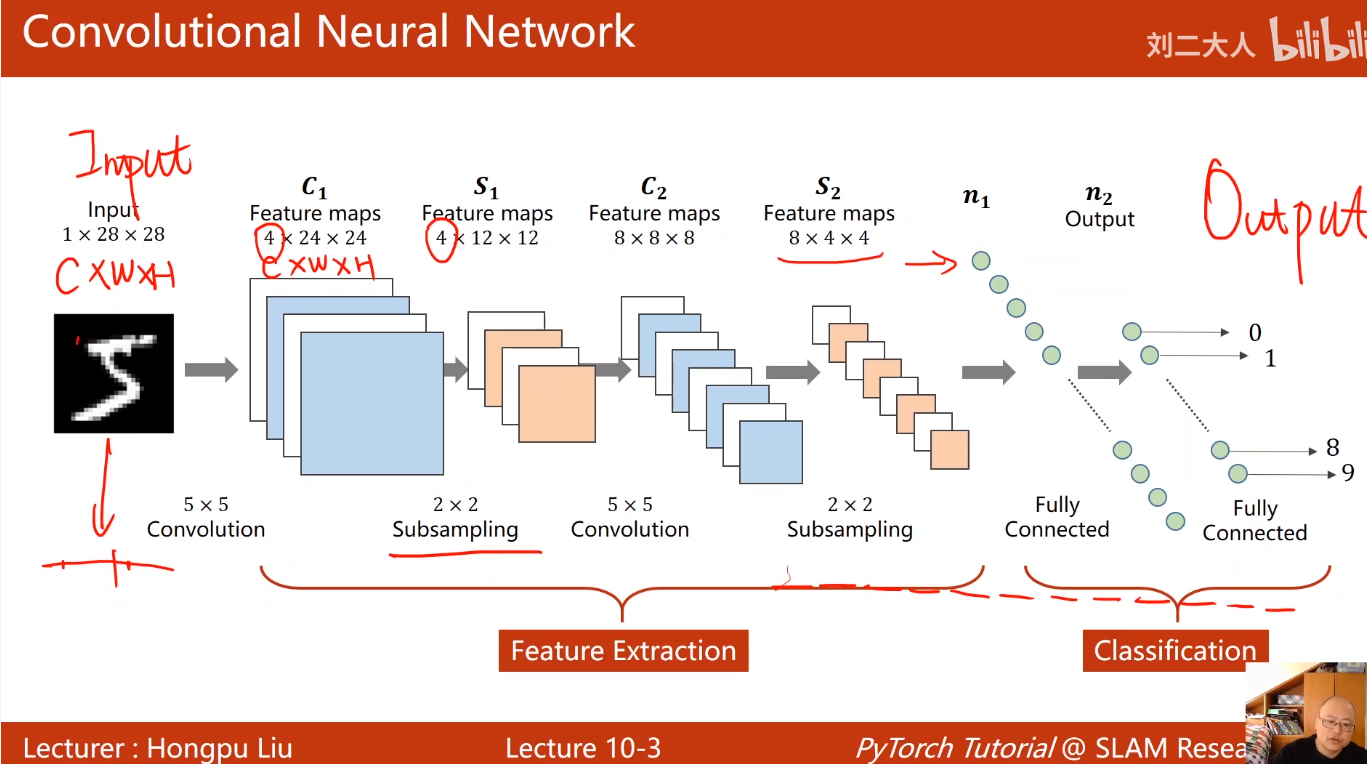
特征提取层和分类层


In [3]:
import torch
in_channels, out_channels = 5,10
width, height = 100,100
kernel_size = 3
batch_size = 1

# 小批量数据
inputs = torch.randn(batch_size,  # B
                   in_channels,   # n
                   width,         # W
                   height)        # H

conv_layer = torch.nn.Conv2d(in_channels, 
                             out_channels,
                             kernel_size=kernel_size)

output = conv_layer(inputs)

print(inputs.shape)
print(output.shape)
print(conv_layer.weight.shape)

torch.Size([1, 5, 100, 100])
torch.Size([1, 10, 98, 98])
torch.Size([10, 5, 3, 3])


In [8]:
inputs =[3,4,5,6,7,
        2,4,6,8,2,
        1,6,7,8,4,
        9,7,4,6,2,
        3,7,5,4,1]
#                                  B  C  W  H
inputs = torch.Tensor(inputs).view(1, 1, 5, 5)

conv_layer = torch.nn.Conv2d(1, 1, kernel_size=3, padding=1,stride=2, bias=False)
#                                           输入 输出 宽度 高度
kernel = torch.Tensor([1,2,3,4,5,6,7,8,9]).view(1, 1, 3, 3)
#                
conv_layer.weight.data = kernel.data

output = conv_layer(inputs)
print(output)

tensor([[[[ 91., 225., 131.],
          [192., 282., 122.],
          [ 96., 110.,  31.]]]], grad_fn=<MkldnnConvolutionBackward>)


In [12]:
maxpooling_layer = torch.nn.MaxPool2d(kernel_size=2)
output = maxpooling_layer(inputs)
print(output)

tensor([[[[4., 8.],
          [9., 8.]]]])


In [49]:
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(320, 10)
    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.pooling(self.conv1(x)))
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x
model = Net()

选择gou

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

将模型和所有权重全部放到显卡里

In [51]:
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)

In [28]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

In [29]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.137,),(0.308,))
])


In [32]:

train_dataset = datasets.MNIST(root='../dataset/mnist',
                               train=True,
                               download=True,
                               transform=transform)
train_loader = DataLoader(dataset=train_dataset, 
                         shuffle=True,
                         batch_size=batch_size)

test_dataset = datasets.MNIST(root="../dataset/mnist",
                             train=False,
                             download=True,
                             transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         shuffle=False,
                         batch_size=batch_size)

In [33]:
import torch.optim  as optim

In [55]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [56]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs,target = data
        # 模型和数据要放在同一块显卡上
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if batch_idx %300 == 299:
            print('[%d, %5d] loss:%.3f'%(epoch+1, batch_idx+1, running_loss/2000))
            running_loss = 0
def test():
    correct = 0
    total = 0
    # 不用计算梯度
    with torch.no_grad():
        for data in test_loader:
            images, label = data
            images,label = images.to(device),label.to(device)
            # 预测
            outputs = model(images)
            # 每行最大的下标值                  按照第一个维度 横着
            _, predicted = torch.max(outputs.data, dim=1)
            total += label.size(0)
            # 张量之间的比较运算
            correct += (predicted == label).sum().item()
    print('Accuracy on test set : %d %%'%(100 * correct/total))       

In [57]:
for epoch in range(10):
    train(epoch)
    test()

[1,   300] loss:0.293
[1,   600] loss:0.127
[1,   900] loss:0.067
Accuracy on test set : 89 %
[2,   300] loss:0.055
[2,   600] loss:0.049
[2,   900] loss:0.045
Accuracy on test set : 92 %
[3,   300] loss:0.039
[3,   600] loss:0.038
[3,   900] loss:0.036
Accuracy on test set : 93 %
[4,   300] loss:0.033
[4,   600] loss:0.032
[4,   900] loss:0.029
Accuracy on test set : 94 %
[5,   300] loss:0.028
[5,   600] loss:0.026
[5,   900] loss:0.026
Accuracy on test set : 95 %
[6,   300] loss:0.025
[6,   600] loss:0.024
[6,   900] loss:0.023
Accuracy on test set : 95 %
[7,   300] loss:0.022
[7,   600] loss:0.021
[7,   900] loss:0.020
Accuracy on test set : 96 %
[8,   300] loss:0.019
[8,   600] loss:0.019
[8,   900] loss:0.019
Accuracy on test set : 96 %
[9,   300] loss:0.018
[9,   600] loss:0.017
[9,   900] loss:0.018
Accuracy on test set : 97 %
[10,   300] loss:0.016
[10,   600] loss:0.017
[10,   900] loss:0.016
Accuracy on test set : 97 %
